In [1]:
%pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\rachi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
%pip install torchvision


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\rachi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [4]:
# Read in a image from torchvision
img = torchvision.io.read_image("1colour.jpg")
print(img.shape)
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

torch.Size([3, 625, 639])


In [5]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], dtype=torch.float64)

In [6]:
import sklearn

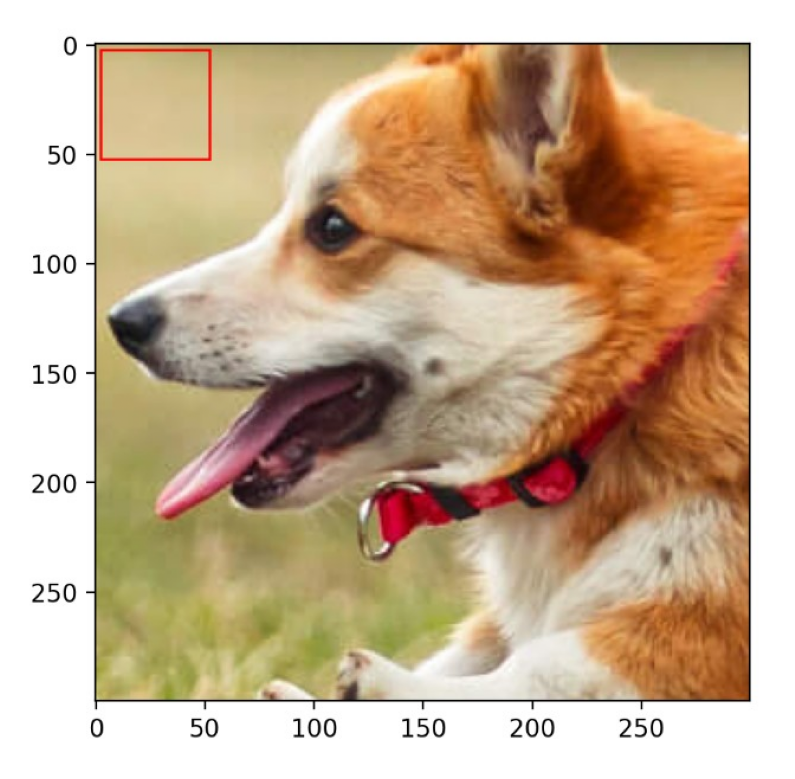

In [7]:
plt.imshow(rearrange(img_scaled, 'c h w -> h w c').numpy())
plt.axis('off')
img=img_scaled

In [8]:
# Image dimensions
height, width = img.shape[1], img.shape[2]

# Flatten the image tensor
img_flat = img.permute(1, 2, 0).reshape(-1, 3)  # Shape: (N, 3) where N is the number of pixels

# Extract coordinates
x, y = torch.meshgrid(torch.arange(width), torch.arange(height))
X = x.flatten()
Y = y.flatten()

# Extract RGB values
R = img_flat[:, 0].float()  # Red channel
G = img_flat[:, 1].float()  # Green channel
B = img_flat[:, 2].float()  # Blue channel

In [9]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [10]:
dog_X, dog_Y = create_coordinate_map(img)

dog_X.shape, dog_Y.shape

(torch.Size([399375, 2]), torch.Size([399375, 3]))

In [11]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [12]:
# MinMaxScaler from -1 to 1
from sklearn import preprocessing
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [13]:
X_rff = create_rff_features(dog_X_scaled, 5000, 0.008)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [ ]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)


train(net, 0.005, X_rff, dog_Y, 100)

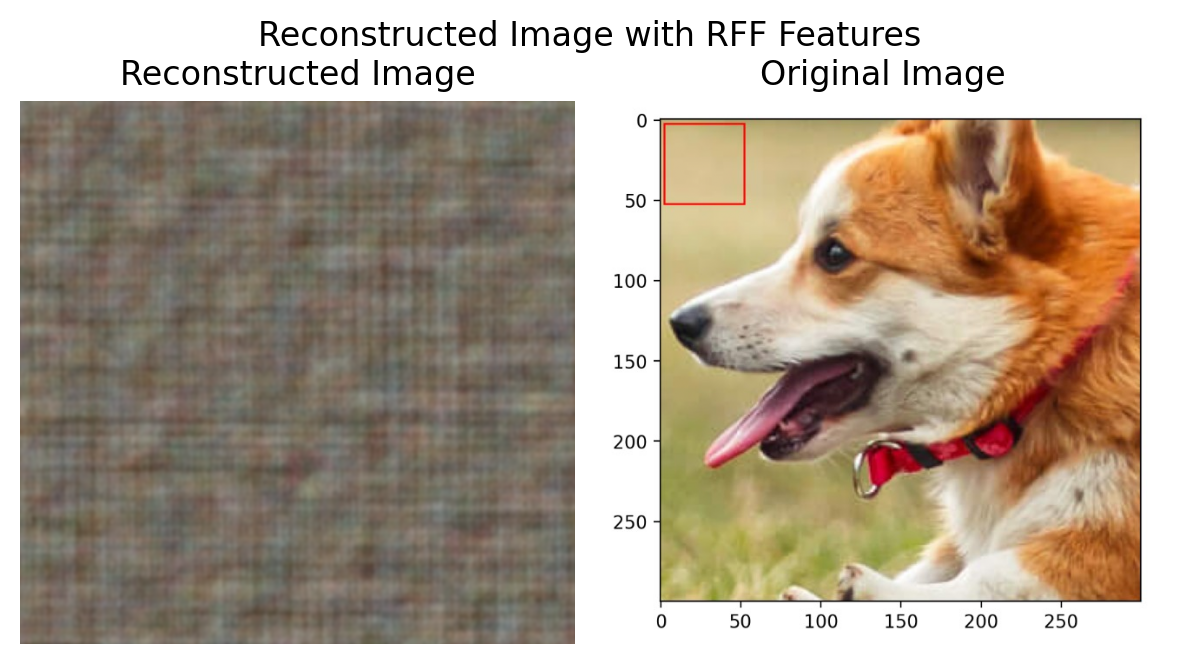

In [ ]:
plot_reconstructed_and_original_image(img, net, X_rff, title="Reconstructed Image with RFF Features")

In [6]:
%pip install scikit-image


   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.8 MB 660.6 kB/s eta 0:00:20
   ---------------------------------------- 0.1/12.8 MB 871.5 kB/s eta 0:00:15
   - -------------------------------------- 0.3/12.8 MB 2.3 MB/s eta 0:00:06
   -- ------------------------------------- 1.0/12.8 MB 4.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.9/12.8 MB 7.5 MB/s eta 0:00:02
   -------- ------------------------------- 2.9/12.8 MB 9.2 MB/s eta 0:00:02
   --------- ------------------------------ 2.9/12.8 MB 9.3 MB/s eta 0:00:02
   ---------- ----------------------------- 3.4/12.8 MB 8.1 MB/s eta 0:00:02
   ------------ --------------------------- 4.2/12.8 MB 8.3 MB/s eta 0:00:02
   ---------------- ----------------------- 5.4/12.8 MB 9.6 MB/s eta 0:00:01
   ------------------- -------------------- 6.3/12.8 MB 10.0 MB/s eta 0:00:01
   -----


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\rachi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from skimage import io
from skimage.metrics import peak_signal_noise_ratio as psnr

# Step 1: Load an image and prepare data
image = io.imread('1colour.jpg').astype(np.float32)  # Replace with actual image path
h, w, c = image.shape

# Generate pixel coordinates (X, Y)
X_coords, Y_coords = np.meshgrid(np.arange(h), np.arange(w))
coords = np.stack([X_coords.ravel(), Y_coords.ravel()], axis=-1)  # Shape: (h*w, 2)

# Extract color values (R, G, B)
pixels = image.reshape(-1, 3)  # Shape: (h*w, 3)

# Step 2: Compute Random Fourier Features
def random_fourier_features(coords, num_features, gamma=0.1):
    np.random.seed(0)  # For reproducibility
    # Random weights and bias
    W = np.random.randn(2, num_features) * gamma
    b = 2 * np.pi * np.random.rand(num_features)
    # Compute Fourier features
    fourier_features = np.cos(np.dot(coords, W) + b)
    return fourier_features

num_features = 5000 # You can adjust this based on performance/accuracy tradeoff
fourier_features = random_fourier_features(coords, num_features)

# Step 3: Train a Linear Regression model
model_r = LinearRegression()
model_g = LinearRegression()
model_b = LinearRegression()

# Fit the models for R, G, B channels
model_r.fit(fourier_features, pixels[:, 0])
model_g.fit(fourier_features, pixels[:, 1])
model_b.fit(fourier_features, pixels[:, 2])

# Step 4: Reconstruct the image
r_pred = model_r.predict(fourier_features).reshape(h, w)
g_pred = model_g.predict(fourier_features).reshape(h, w)
b_pred = model_b.predict(fourier_features).reshape(h, w)

reconstructed_image = np.stack([r_pred, g_pred, b_pred], axis=-1).astype(np.uint8)

# Step 5: Calculate RMSE and PSNR
# Step 5: Calculate RMSE and PSNR for each channel separately
rmse_r = np.sqrt(mean_squared_error(image[:, :, 0], reconstructed_image[:, :, 0]))
rmse_g = np.sqrt(mean_squared_error(image[:, :, 1], reconstructed_image[:, :, 1]))
rmse_b = np.sqrt(mean_squared_error(image[:, :, 2], reconstructed_image[:, :, 2]))

rmse = np.mean([rmse_r, rmse_g, rmse_b])  # Average RMSE across the channels
psnr_value = psnr(image, reconstructed_image)

# Step 6: Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title(f"Reconstructed Image\nRMSE: {rmse:.4f}, PSNR: {psnr_value:.2f} dB")
plt.axis('off')

plt.show()
